<a href="https://colab.research.google.com/github/kswam/Fake-News-Detection/blob/main/fake_news_detection_using_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import h5py
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset = pd.read_csv("/content/drive/MyDrive/fake news/train.csv")
dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
dataset.shape

(20800, 5)

In [5]:
dataset.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
dataset = dataset.dropna(subset = ["text"])
dataset.isnull().sum()

id           0
title      558
author    1918
text         0
label        0
dtype: int64

In [7]:

y = dataset["label"].values
print(y.shape)
y =y.reshape(-1,1)
print(y.shape)

(20761,)
(20761, 1)


In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
set_stopwords = set(stopwords.words('english'))
set_stopwords.discard('no')
set_stopwords.discard('not')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

In [10]:
text_data = []
for news in dataset["text"]:
  news =news.lower()
  news = re.sub('[^a-z ]','',news)
  list_words = news.split(' ')
  data = []
  for word in list_words:
    if word not in set_stopwords:
      data.append(porter.stem(word))
  data = ' '.join(data)
  text_data.append(data)



In [11]:
len(max(text_data))

4922

In [12]:
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences 

In [33]:
MAX_NB_WORDS = 100000 # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding
VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 200 # embedding dimensions for word vectors

In [34]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)
word_index =  tokenizer.word_index
print("Vocabulary size:",len(word_index))

Vocabulary size: 145563


In [35]:
pad_seq = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)


In [19]:
training_samples = int(20761*0.8)
testing_samples = 5572 - training_samples
X_train = pad_seq[:training_samples]
X_test = pad_seq[training_samples:]
y_train = y[:training_samples]
y_test = y[training_samples:]

In [20]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-01-23 11:35:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-23 11:35:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-23 11:35:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [21]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [22]:
!ls
!pwd


drive		   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [36]:
from numpy import zeros
from numpy import array
from numpy import asarray
embeddings_index = {}
f = open('glove.6B.200d.txt',mode='rt',encoding='utf-8')

for line in f:
 values = line.split()
 word = values[0]
 embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
   embedding_matrix[i] = embedding_vector


EMBEDDING_DIM = 4922
embedding_matrix = zeros((len(word_index)+1, ))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector


In [37]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding



In [40]:
from keras.models import Sequential
from keras.layers import Embedding,Dense,LSTM,Dropout,GlobalMaxPooling1D

In [48]:
rnn_model = Sequential()

rnn_model.add(Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length = MAX_SEQUENCE_LENGTH,
                            trainable=False
                           ))
rnn_model.add(LSTM(60,return_sequences=True,name="lstm_layer"))
rnn_model.add(GlobalMaxPooling1D())
rnn_model.add(Dropout(0.1))
rnn_model.add(Dense(50,activation="relu"))
rnn_model.add(Dropout(0.1))
rnn_model.add(Dense(1,activation="sigmoid"))
rnn_model.build()
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 200)         29112800  
                                                                 
 lstm_layer (LSTM)           (None, 1000, 60)          62640     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

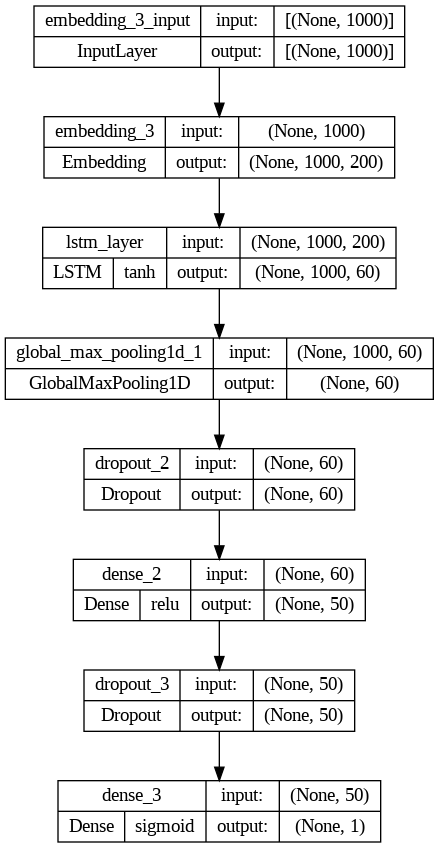

In [49]:
import tensorflow as tf
tf.keras.utils.plot_model(rnn_model,show_shapes = True, show_layer_activations=True)

In [54]:
rnn_model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
batch_size = 128
epochs = 10

history = rnn_model.fit(X_train,y_train,epochs = epochs,batch_size=batch_size)

Epoch 1/10
130/130 [==============================] - 8s 45ms/step - loss: 0.0438 - accuracy: 0.9841
Epoch 2/10
130/130 [==============================] - 6s 45ms/step - loss: 0.0376 - accuracy: 0.9872
Epoch 3/10
130/130 [==============================] - 6s 44ms/step - loss: 0.0287 - accuracy: 0.9902
Epoch 4/10
130/130 [==============================] - 6s 44ms/step - loss: 0.0233 - accuracy: 0.9919
Epoch 5/10
130/130 [==============================] - 6s 45ms/step - loss: 0.0234 - accuracy: 0.9918
Epoch 6/10
130/130 [==============================] - 6s 45ms/step - loss: 0.0187 - accuracy: 0.9933
Epoch 7/10
130/130 [==============================] - 6s 45ms/step - loss: 0.0163 - accuracy: 0.9944
Epoch 8/10
130/130 [==============================] - 6s 45ms/step - loss: 0.0128 - accuracy: 0.9959
Epoch 9/10
130/130 [==============================] - 6s 45ms/step - loss: 0.0098 - accuracy: 0.9971
Epoch 10/10
130/130 [==============================] - 6s 45ms/step - loss: 0.0102 - accura

In [55]:
print("Accuracy of the model on Training Data is - " , rnn_model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , rnn_model.evaluate(X_test,y_test)[1]*100 , "%")

519/519 [==============================] - 9s 16ms/step - loss: 0.0030 - accuracy: 0.9995
Accuracy of the model on Training Data is -  99.94580745697021 %
130/130 [==============================] - 2s 16ms/step - loss: 0.1451 - accuracy: 0.9632
Accuracy of the model on Testing Data is -  96.31591439247131 %
